# Process the data from Euro Satellite
## Land Segmentation

In [2]:
import os
import random
from tqdm.notebook import tqdm

#Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning Libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms
from custom_datasets import EuroSAT

# used for reproducing same results
SEED = 42
np.random.seed(SEED)

In [31]:
# Check for gpu on google colab

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
#print(torch.cuda.get_device_name(0))


# This code is for using mps on Mac device
# check for device 
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    torch.set_default_device("mps")
    device=torch.device('mps')
    #device = "mps"
else:
    device = "cpu"
    
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device : {}".format(device))


Device : mps


In [4]:
# Uncomment this for google drive, Commented for running on local

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Euosat Dataset
https://github.com/phelber/EuroSAT


27,000 labeled and geo-referenced image patches of size 64 x 64`
Labels are for 10 classes or categories\

In [5]:
#!wget https://madm.dfki.de/files/sentinel/EuroSAT.zip --no-check-certificate
#!unzip -q EuroSAT.zip
#!rm EuroSAT.zip

# Data Transformations
- Augmentation
#### Random Transformations to the Input Data iamges to created additional training data
- Normalization
#### Using model pre-trained on ImageNet dataset, normalization will make sure input data is normalized to the mean and std dev of the imagenet dataset

In [6]:
input_size = 64
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

#Transformations involve: random crop, vertical and horizontal flip
# convert to tensor
# normalize using imagenet mean and std deviation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [7]:
data_dir = './2750'
dataset = datasets.ImageFolder(data_dir)


class_names = dataset.classes
print(class_names)
print(len(dataset))

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
27000


# Split the Dataset into Train, Validation and Test

In [9]:
# make three copies of dataset to apply 3 different transformations
train_data = EuroSAT(dataset, transform = train_transform)
val_data = EuroSAT(dataset , transform = val_transform)
test_data = EuroSAT(dataset , transform = test_transform)

train_size = 0.70
val_size = 0.15
test_size = 0.15

# gather indices from the dataset's range
indices = list(range(len(dataset)))

# split the dataset into train, validation and test sets by using indices ranges calculated from train, val and test sizes
train_split = int(np.floor(train_size * len(dataset)))
val_split = int(np.floor(val_size * len(dataset)))
np.random.shuffle(indices)




# Create PyTorch Dataloaders

In [10]:
# Create 3 dataloader objects for getting iterators of data
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_data = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)


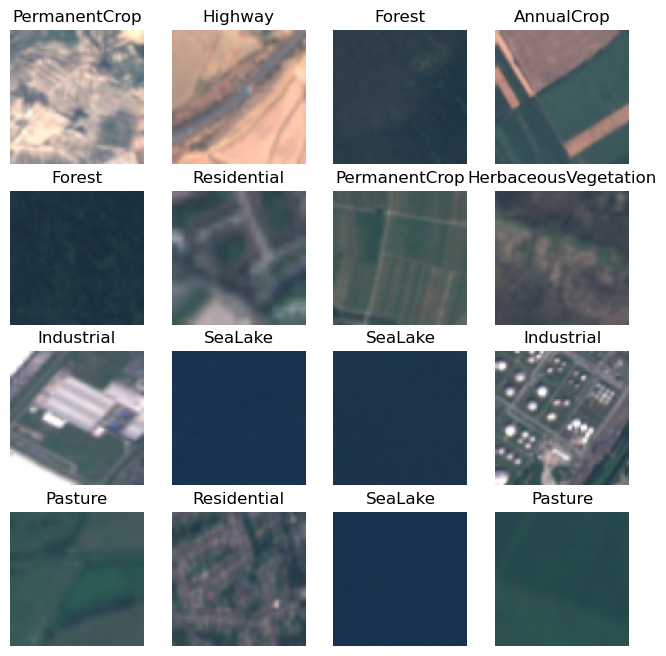

In [11]:
# Visualization of some sample images from the dataset's batch

n = 4
# data loader on EuroSAT dataset would return following two tensors:
# A tensor of images of shape (batch_size, C, H, W)
# A tensor of labels of shape (batch_size,)
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    # Pick (i * n + j)-th image in the batch and transpose it to (H, W, C) for display
    # Also convert tensor to numpy array before transposing
    image = inputs[i * n+j].numpy().transpose((1, 2, 0))
    # apply normalization correction - reverse normalization
    # np.clip(..., 0, 1) keeps the values between 0 and 1
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)


    # get the corresponding label from the the classes tensor
    title = class_names[classes[i * n + j]]

    # display the image in the corrsponding subplot position
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')




# Exploratory Data Analysis

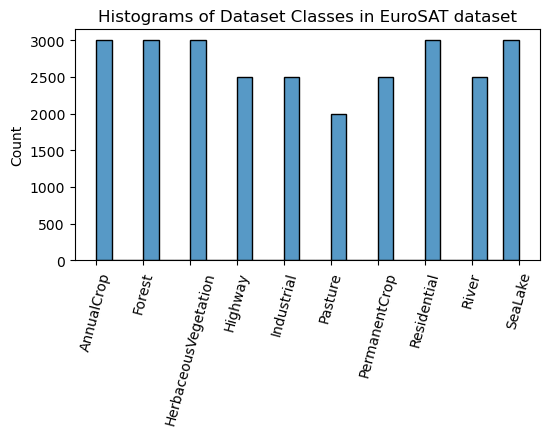

In [12]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)


# How many images of each class
hist.set_xticks(range(len(class_names)))
hist.set_xticklabels(dataset.classes, rotation=75)
hist.set_title("Histograms of Dataset Classes in EuroSAT dataset")

plt.show()

# Design Neural Network: RESNET
### RESTNET: CNN that uses skip conections from previous layers to deeper layers to solve vaninshing gradient (no learning ) problem
### RESNET = Residual Connections
### RESNET50 is 50 layers deep
### Architecture of RESNET50:
- Convolutional Input layers
- Bottlenecks: Each containinng - 1x1 Conv-> 3x3 Conv -> 1x1 Conv
- Fully Connected Layer

In [34]:
# Use the pretrained RESNET model from Pytorch library's Model class
# Initialize RESNET to contain default weights hence pretrained on Imagenet
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

# modify the fully connected layer in the loaded / pretrained RESNET50 model
# To contain output feature count = number of classes in EuroSAT dataset
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))

model = model.to(device)
#torchsummary.summary(model, (3, 224, 224), device = device)

# Model Training and Evaluation
- Create Model Instance with criterion(loss function - Cross Entropy Loss), Optimizer (SGD), and hyper-parameters specified
- Train model (update weights)
- Evaluate on Test data
- Repeat for n-epochs



In [35]:
epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [36]:
# Define the training function
def train_model(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, lables) in enumerate(tqdm(dataloader)):
    #make sure inputs and lables for training at moved to same device as model (gpu)
    print(device)
    inputs = inputs.to(device)
    lables = lables.to(device)

    # set all gradients in optimizer to zero
    optimizer.zero_grad()

    # forward pass through the network to calculate output
    outputs = model(inputs)

    #  calculate loss using outputs calculated by model and lables from training data
    loss = criterion(outputs, lables)

    # perform backward pass to calculate gradient calculations
    loss.backward()

    #update weights by takin one step of optimizer
    optimizer.step()

    #calculate statistics to evaluate model parameters trained so far
    # identify which class has maximum probability evaluated by the model
    _, predicted = torch.max(outputs, 1)

    # Multiplying the loss by the batch size gives the total loss for the batch
    running_loss += loss.item() * inputs.size(0)

    # calculate the count of total correct predictions in the batch
    running_total_correct += torch.sum(predicted == lables)

  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = running_total_correct / len(dataloader.dataset) * 100
  print(f'Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy: .2f}')

  return epoch_loss, epoch_accuracy




In [37]:
def evaluate_model(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, lables) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    lables = lables.to(device)

    with torch.no_grad():
      outputs = model(inputs)
      loss = criterion(outputs, lables)

      _, predicted = torch.max(outputs, 1)

      running_loss += loss.item() * inputs.size(0)
      running_total_correct = torch.sum(predicted == lables)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = running_total_correct / len(dataloader.dataset) * 100
    print(f'{phase} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy: .2f}')

    return epoch_loss, epoch_accuracy




In [38]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  best_loss = np.inf
  best_model = None

  for epoch in range(n_epochs):
    print(f'Epoch: {epoch+1}/{n_epochs}')
    model = train_model(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate_model(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

In [39]:
best_model = fit(model, train_loader, val_loader, epochs, lr, criterion, optimizer)

Epoch: 1/10


  0%|          | 0/1688 [00:00<?, ?it/s]

RuntimeError: Expected a 'mps:0' generator device but found 'cpu'

# Model Performance on Test Data

In [36]:
test_loss, _ = evaluate_model(best_model, test_data , criterion, phase="test")

  0%|          | 0/1688 [00:00<?, ?it/s]

test Loss: 0.00; Accuracy:  0.06


# Save the model

In [37]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"

if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

'./drive/My Drive/Colab Notebooks/models/best_model.pth'

In [38]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(),model_file)
  print(f'Model saved to {model_file}')

In [39]:
save_model(best_model, model_file)

Model saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth


# Load model from saved location

In [42]:
def load_model(model_file):
  if not os.path.exists(model_file):
    model_file = 'best_model.pth'

  if not os.path.exists(model_file):
    model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    print(f'Model successfully loaded from {model_file}')
    return model

In [43]:
model_from_memory = load_model(model_file)